## **Fake News Detector - rozwiązanie konkursowe w ramach kursu Praktyczne Przetwarzanie Języka Naturalnego - DataWorkshop**

Import/instalacja wykorzystywanych bibliotek

In [18]:
import numpy as np
import pandas as pd

from pathlib import Path

from flair.datasets import ClassificationCorpus
from flair.data import Sentence, Dictionary
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings, FlairEmbeddings, TransformerDocumentEmbeddings, DocumentPoolEmbeddings, TransformerWordEmbeddings, StackedEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from torch.optim.adam import Adam
from flair.visual.training_curves import Plotter

import texthero as hero

from sklearn import metrics
from sklearn.cluster import KMeans

from scipy.spatial import distance

from html import unescape
import re

pd.set_option("display.max_colwidth", -1)

Wczytanie danych

In [89]:
data_dir = '../input'
output_dir = '../output'

train_dir = f'{data_dir}/train_fake_2.h5'
test_dir = f'{data_dir}/test_fake_2.h5'

In [20]:
df_train = pd.read_hdf(train_dir) 
df_test = pd.read_hdf(test_dir) 

In [21]:
df_train.head()

,id,title,text,is_fake
0,0,"education,message-machine,taxes","There are 321,092 public school teachers in Texas. And there are 313,850 non-teachers in our public schools.",0
1,3,How to cope during the novel coronavirus (COVID-19) pandemic,NaN,0
2,8,"economy,jobs,women","Under Barack Obama and the big government economy, the median wage for women has dropped $733.",1
3,10,jobs,An iron ore mine in northern Wisconsin could operate for 100 years and generate billion of dollars in economic activity.,0
4,11,COVID-19: Herd immunity may occur sooner than previously,NaN,0


In [22]:
df_test.head()

,id,title,text
0,1,environment,"For every [coyote] they kill, the population will replace and usually multiply."
1,2,Double bomb attack kills 31 in Syrian Kurdish city state TV,Wednesday 27 Jul 2016 Double bomb attack kills 31 in Syrian Kurdish city state TV AFP Print Tweet Views 729 Related IS group claims responsibility for attack on Syrian town Double bomb attack kills 31 in Syrian Kurdish city state TV -A double bomb attack killed 31 people in the Kurdish-majority city of Qamishli in northeastern Syria on Wednesday Syrian state television reported. In a breaking news alert it said rescue workers were still retrieving victims of the blasts and that at least 170 people had also been wounded.
2,4,health-care,"An Iowa policy ""provides for a state round up of Iowa citizens who might be exposed to the swine flu virus."""
3,5,"health-care,women","A government panel that didn't include cancer specialists says women shouldn't receive mammograms until age 50...If government takes over health care, recommendations like these could become the law for all kinds of diseases."
4,6,"health-care,medicare,new-hampshire-2012","When the Republicans were in charge, they actually expanded government health care with the prescription drug program."


Sprawdźmy rozmiary naszych danych treningowych i testowych, a także ewentualne brakujące dane

In [23]:
df_train.shape, df_test.shape

((4862, 4), (4863, 3))

In [24]:
df_train.isnull().sum()

id         0   
title      1   
text       1251
is_fake    0   
dtype: int64

In [25]:
df_test.isnull().sum()

id       0   
title    1   
text     1198
dtype: int64

Zarówno w zbiorze testowym jak również w zbiorze treningowym brakuje dużo danych z kolumny 'text'.

Zastępujemy brakujące dane słowem 'unknown'

In [26]:
df_train.fillna('unknown', inplace=True)
df_test.fillna('unknown', inplace=True)

Łączymy oba zbiory w jeden wspólny dataframe

In [27]:
df = pd.concat([df_train, df_test], sort=False)

df.shape

(9725, 4)

Przyjrzyjmy się danym

Zobaczmy jak wygląda kilka przykładowych newsów, które są i nie są fake'ami 

In [30]:
#kilka fake newsów
df[df['is_fake'] == 1].sample(10)

,id,title,text,is_fake
4065,8218,NASA Will Pay You 18000 USD To Stay In Bed And Smoke Weed For 70 Straight Days,unknown,1.0
3651,7369,A painting depicting children in face masks was created as a mural for the Denver airport in 1994 proving the COVID-19 pandemic was planned.,unknown,1.0
1940,3957,"energy,government-regulation",Says Dow Chemical decided to build a plant in Saudi Arabia rather than Oklahoma due to the impact of environmental regulations on the supply of natural gas.,1.0
738,1488,Israeli strike on Syrian town kills pro-regime fighters,"29 July 2015 An Israeli airstrike on a government-held village on the Syrian side of the Golan Heights ceasefire line killed five pro-regime forces on Wednesday a monitoring group said. Tags Syria Golan Heights Israeli airstrike Hezballah SOHR An Israeli airstrike on a government-held village on the Syrian side of the Golan Heights ceasefire line killed five pro-regime forces on Wednesday a monitoring group said. ""An Israeli plane hit a car inside the town of Hader killing two men from (Lebanese Shia group) Hezballah and three men from the pro-regime popular committees in the town"" said Rami Abdel Rahman director of the Syrian Observatory for Human Rights. Hader is a Druze village that lies along the ceasefire line with the Israeli-occupied portion of the Golan Heights plateau to the west and the border with Damascus province to the northeast. An Israeli army spokeswoman declined to comment on the incident. According to Hezballahs official television station al-Manar ""two members of Syrias (pro-regime militia) National Defence Forces were killed when an Israeli drone targeted their car at the entrance of Hader in Quneitra province."" The National Defence Forces has fighters operating throughout Syria. Lebanons Hezballah is a close ally of the Syrian government and has dispatched fighters to bolster the army against the uprising that began in March 2011. Rebel fighters including Islamists surrounded the village of Hader on June 17 after fierce clashes with loyalist militia in the area. Israels own significant Druze minority has expressed concern that their brethren in Syria would be targeted by rebels there. The Druze are a secretive offshoot of Shia Islam. Officials say there are 110000 of them in northern Israel and another 20000 in the Israeli-occupied Golan. Israel seized 1200 square kilometres (460 square miles) of the Golan Heights from neighbouring Syria in the 1967 Six Day War.",1.0
2156,4380,Zarif Urges Intl. Fact-Finding Mission to Probe Syria Gas Attack.,April 10 2017 Zarif Urges Intl. Fact-Finding Mission to Probe Syria Gas Attack. Iran Foreign Minister Mohammad Javad Zarif Iran - Live News - Middle East - News - Top Tweet Iranian Foreign Minister Mohammad Javad Zarif has reiterated the Islamic Republics stance on the need for the establishment of an international fact-finding committee to investigate the recent chemical attack in Syria. Zarif made the call during phone conversations on Monday with the European Union High Representative for Foreign Affairs and Security Policy Federica Mogherini as well as his Russian Omani Syrian and Algerian counterparts Sergei Lavrov Yusuf bin Alawi Walid al-Muallem and Mourad Medelci respectively. The senior officials exchanged views about the terrible suspected chemical attack in the Syrian town of Khan Shaikhoun in Idlib Province which killed at least 86 people. Anti-Damascus militants and Western countries rushed to blame the Syrian government of President Bashar al-Assad for the incident without providing any evidence to support their accusations. Syria has categorically denied carrying out the gas attack with the foreign minister stressing that an Idlib airstrike had targeted a depot where terrorists stored chemical weapons.,1.0
1215,2469,"city-government,government-regulation,message-machine-2012,market-regulation,water",Says we could have saved ourselves the cost of building the Powell Butte water reservoir.,1.0
1545,3135,hea

In [31]:
#kilka prawdziwych newsów
df[df['is_fake'] == 0].sample(10)

,id,title,text,is_fake
3223,6511,More Guidance on Inpatient Management of Blood Glucose in COVID-19,unknown,0.0
2673,5416,"economy,job-accomplishments,jobs","Over the last 10 years, Texas created 33 percent of the net new jobs nationwide.",0.0
2100,4262,CDC Seroprevalence Survey Types,unknown,0.0
211,438,COVID-19 Rapid Response Team Guidance,unknown,0.0
2735,5539,It’s Time for the Senate to Do Its Job – Congressman Mike Honda – Medium,unknown,0.0
2576,5218,"homeland-security,public-safety","Says Keene, N.H., requested a military-grade armored personnel truck, citing their annual Pumpkin Festival as a possible target for terrorists.",0.0
367,753,"civil-rights,terrorism",The legislation ... that Senator McCain supports would provide the authority for the federal government to surveille American citizens in their own country without any suspicion whatsoever that they're engaging in discussions with terrorists or about criminal activity.,0.0
3746,7595,education,"U.S. teenagers have now fallen behind their counterparts in Ireland, Poland and even Vietnam in math and science.",0.0
4551,9154,European Society of Cardiology 2020 Congress Goes Virtual,unknown,0.0
1128,2285,16 civilians killed in Syrias Hasakeh after motorbike bomber attack,"Published July 5 2016 A motorcycle bomber killed at least 16 civilians outside a bakery in Syrias Hasakeh city Tuesday on the eve of the feast marking the end of Ramadan an official said. The attack which also wounded dozens of people occurred in the neighbourhood of Salihiah ahead of the Eid al-Fitr festival. It was not immediately clear who carried out the attack but Daesh terrorist group has claimed previous bombings in the mainly Kurdish region. Rami Abdel Rahman head of the Syrian Observatory for Human Rights said the attack killed at least 16 people and wounded another 40. The death toll was confirmed to an AFP correspondent. The suicide attacker reportedly detonated his explosives in front of the bakery. ""A suicide bomber on a motorcycle blew himself up in the Salihiah neighbourhood of Hasakeh city"" said Abdel Rahman. Fifteen of the wounded were in critical condition said the head of the Britain-based group that relies on a network of sources on the ground for its information. Hasakeh city is the capital of the province of the same name. Nearly all of the province is controlled by the PKKs Syrian affiliate PYD and its armed wing YPG terrorist organization. The militants have declared an autonomous region across the mainly Kurdish northern areas they hold. A US-backed alliance of Kurds and Arabs The Syrian Democratic Forces alliance has been locked in battle in the neighbouring province of Aleppo for control of the Daesh stronghold of Manbij for more than one month. The SDF launched the offensive in late May and encircled the town and entered its southwestern districts on June 23. More than 280000 people have been killed and millions have been displaced since Syrias conflict broke out in March 2011.",0.0


## MODEL NR 1 (FLAIR)

Preprocessing (przy użyciu hero)

In [49]:
df['clean_title'] = hero.clean(df['title']) # clean_title przyda się na potrzeby topic modeling

Topic modelling przy użyciu flair

In [54]:
#po użyciu hero jeden z tytułów został całkowicie wyczyszczony
df[df['clean_title'] == '']

,id,title,text,is_fake,clean_title
4693,9432,"""On and On""",unknown,0.0,


In [55]:
#więc uzupełniam go słowem 'unknown'
df['clean_title'] = df['clean_title'].apply(lambda x: x if x != '' else 'unknown')

In [56]:
#zapisujemy preprocessowane tytuły do oddzielnego wektora, na którym zrobimy topic modelling
text = df['clean_title']

In [62]:
#funkcja do wyliczenia embeddingów dla naszego tekstu
def calc_embeddings(text, embeddings):
    sent = Sentence(text)
    embeddings.embed(sent)
    return np.array(sent.embedding.detach().cpu())

Wczytanie gotowych embeddingów z biblioteki flair

Wykorzystujemy 3 gotowe embeddingi: news-forward, news-backward i distilbert-base-uncased, które łączymy przy użyciu metody 'StackedEmbeddings'

Metoda 'DocumentRNNEmbeddings' pozwala uzyskać embeddingi dla całych dokumentów. Sieć RNN przyjmuje na wejściu embeddinigi słów dla każdego tokena w dokumencie i zapisuje swój ostatni stan wyjściowy jako embedding całego dokumentu. Możemy wybrać rodzaju sieci rekurencyjnej, która jest użyta. Defaultowo wybierana jest sieć GRU (ale może być też np. LSTM)

In [63]:
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')
bert_embedding = TransformerWordEmbeddings('distilbert-base-uncased', fine_tune=True)

stacked_embeddings = StackedEmbeddings(
    embeddings=[flair_embedding_forward, flair_embedding_backward, bert_embedding])

embeddings = DocumentRNNEmbeddings([stacked_embeddings])

2021-02-07 12:07:49,893 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to C:\Users\AJANKO~1\AppData\Local\Temp\tmp6onghv76


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73034624/73034624 [00:09<00:00, 7567821.86B/s]

2021-02-07 12:07:59,708 copying C:\Users\AJANKO~1\AppData\Local\Temp\tmp6onghv76 to cache at C:\Users\ajankowski\.flair\embeddings\news-forward-0.4.1.pt
2021-02-07 12:07:59,766 removing temp file C:\Users\AJANKO~1\AppData\Local\Temp\tmp6onghv76


2021-02-07 12:08:00,217 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to C:\Users\AJANKO~1\AppData\Local\Temp\tmpva7d_8sq


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73034575/73034575 [00:08<00:00, 8339386.10B/s]

2021-02-07 12:08:09,112 copying C:\Users\AJANKO~1\AppData\Local\Temp\tmpva7d_8sq to cache at C:\Users\ajankowski\.flair\embeddings\news-backward-0.4.1.pt
2021-02-07 12:08:09,169 removing temp file C:\Users\AJANKO~1\AppData\Local\Temp\tmpva7d_8sq


Wyliczamy embeddingi dla oczyszczonych tytułów, zapisujemy je w kolumnie 'vectors'

Niestety wyliczenie embeddingów trochę trwa...

In [64]:
%time df['vectors'] = df['clean_title'].map(lambda text: calc_embeddings(text, embeddings))

Przy użyciu hero.kmeans dzielimy nasze dokumenty na 5 klastrów

In [65]:
%time df['kmeans_k5'] = hero.kmeans(df['vectors'], n_clusters=5)

C:\Users\ajankowski\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
C:\Users\ajankowski\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Wall time: 940 ms


2 klastry są zdecydowanie bardziej liczne niż 3 pozostałe

In [67]:
df['kmeans_k5'].value_counts()

1    3260
2    2661
4    1955
0    1058
3    791 
Name: kmeans_k5, dtype: int64

Zwizualizujmy najczęściej występujące słowa w każdym klastrze

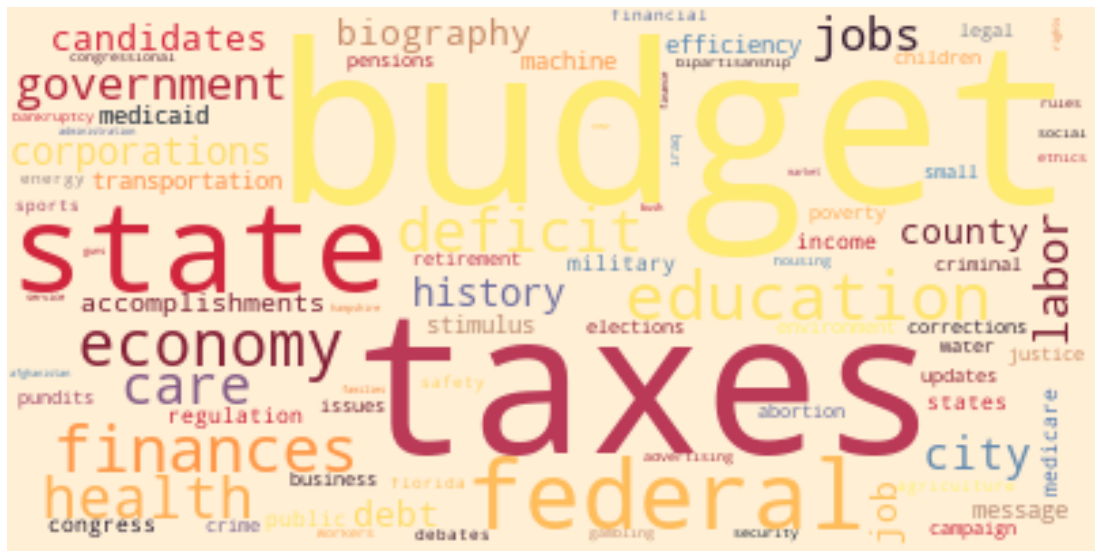

In [68]:
### `Klaster = 0`
hero.visualization.wordcloud(df[df['kmeans_k5'] == 0]['clean_title'])

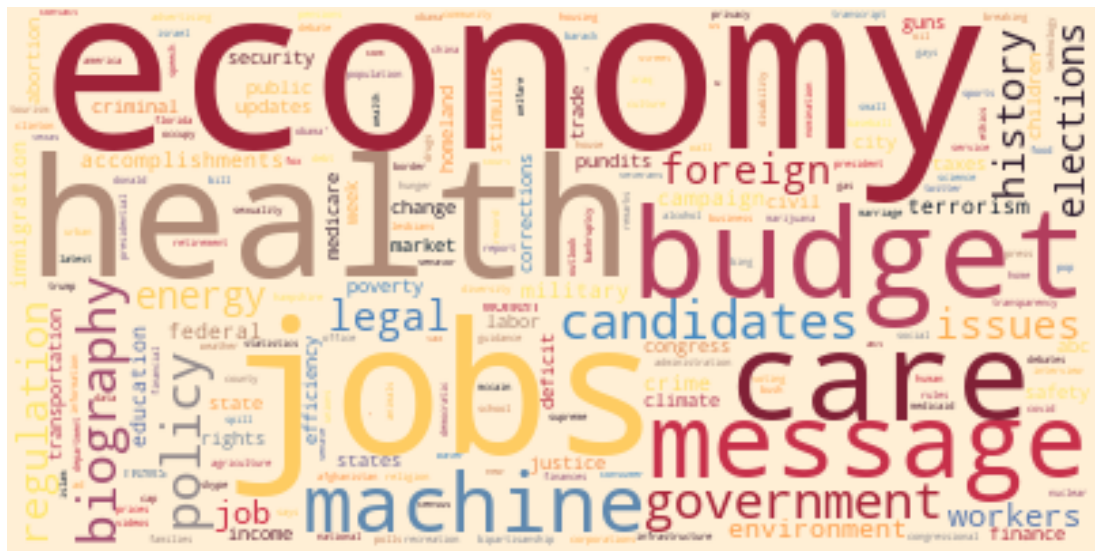

In [73]:
### `Klaster = 1`
hero.visualization.wordcloud(df[df['kmeans_k5'] == 1]['clean_title'])

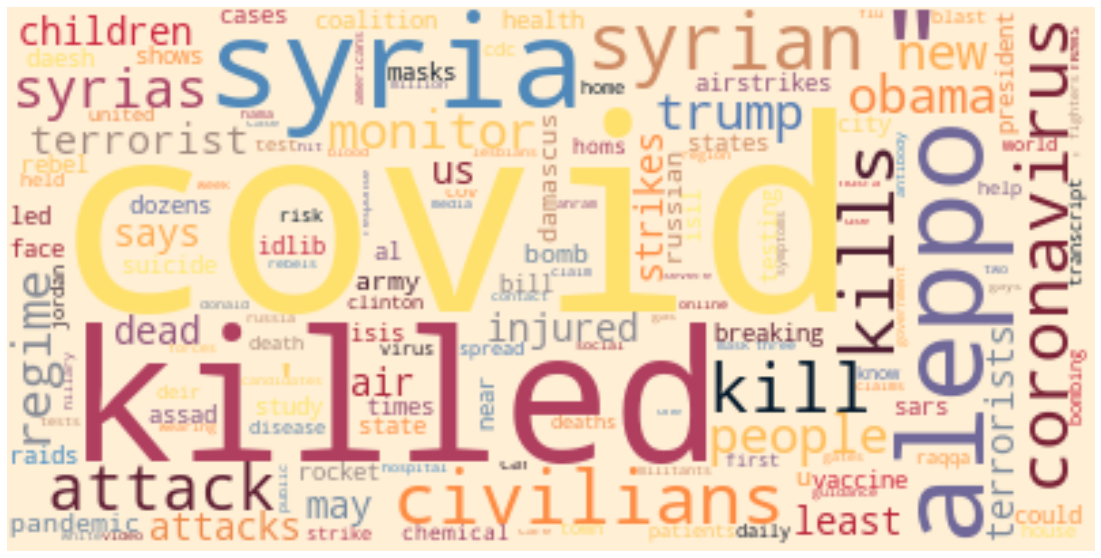

In [74]:
### `Klaster = 2`
hero.visualization.wordcloud(df[df['kmeans_k5'] == 2]['clean_title'])

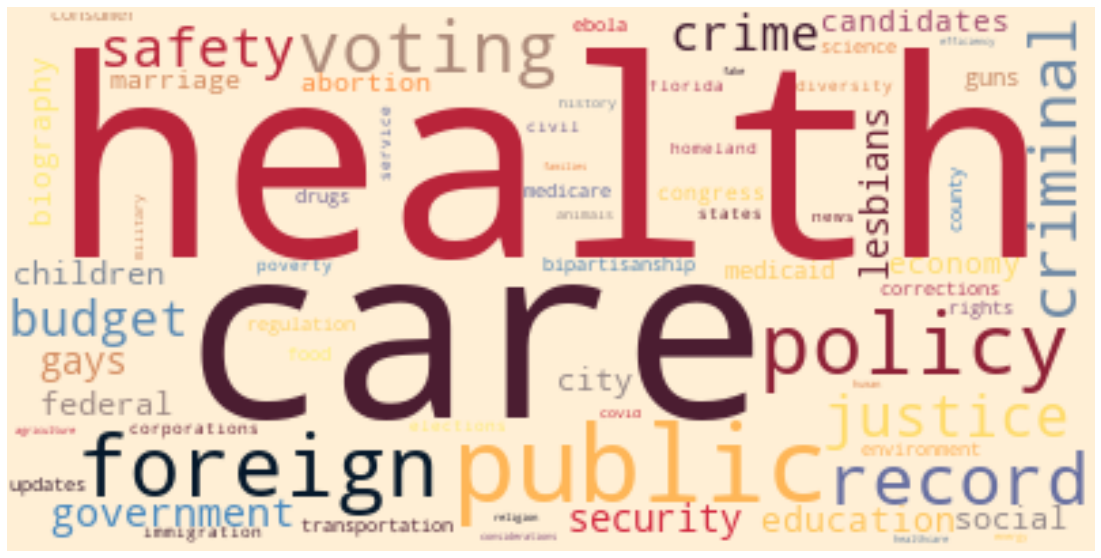

In [75]:
### `Klaster = 3`
hero.visualization.wordcloud(df[df['kmeans_k5'] == 3]['clean_title'])

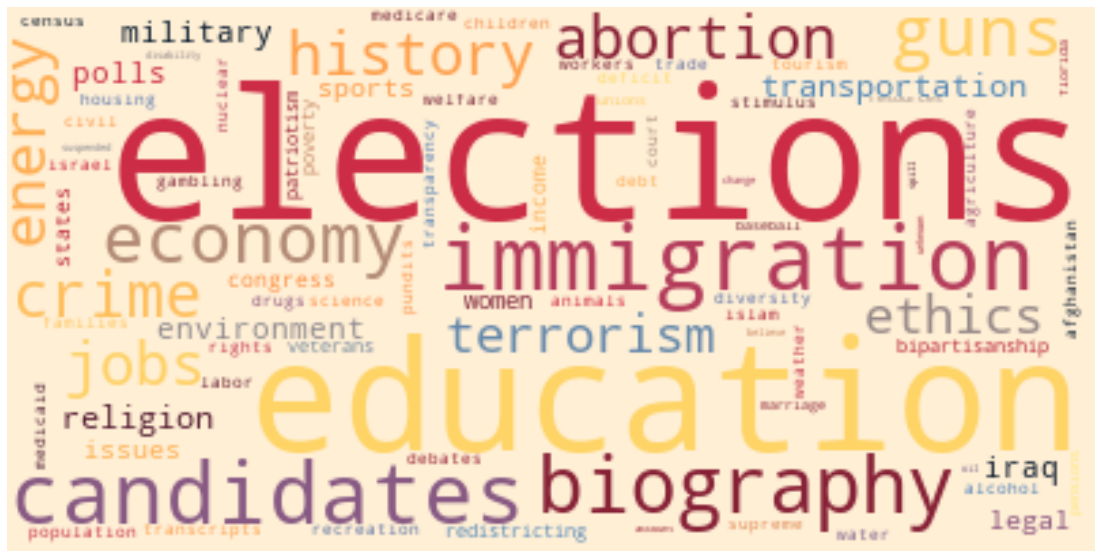

In [76]:
### `Klaster = 4`
hero.visualization.wordcloud(df[df['kmeans_k5'] == 4]['clean_title'])

Sprawdźmy czyli przyporządkowane klastry mają wpływ na to czy news jest prawdziwy czy nie?

In [77]:
df.groupby(['is_fake', 'kmeans_k5'])['id'].count()

is_fake  kmeans_k5
0.0      0            315
         1            970
         2            872
         3            220
         4            552
1.0      0            210
         1            653
         2            489
         3            180
         4            401
Name: id, dtype: int64

Przygotowanie danych do użycia flair

In [82]:
df['topic'] = '__topic__' + df['kmeans_k5'].astype(str)
df['topic_and_text_with_title'] = df['topic'] + ' ' + df['title'] + ' ' + df['text']

In [83]:
df.head()

,id,title,text,is_fake,clean_title,vectors,kmeans_k5,topic,topic_and_text_with_title
0,0,"education,message-machine,taxes","There are 321,092 public school teachers in Texas. And there are 313,850 non-teachers in our public schools.",0.0,education message machine taxes,"[0.24342227, -0.32274532, -0.20751742, 0.9951012, 0.043714464, 0.78941643, 0.04815513, -0.15740073, -0.22234379, -0.3378408, 0.82823426, -0.4937783, -0.9169588, -0.42589563, 0.83573574, 0.572279, -0.11664918, -0.28373587, -0.9339115, -0.05331035, -0.13349319, 0.30038595, -0.07874864, -0.61043096, -0.49464467, -0.29961038, -0.4172676, 0.80537647, 0.073854305, 0.8810047, -0.9953601, -0.36946422, 0.057062715, 0.24248815, -0.49332517, -0.73417234, 0.7489254, -0.067576885, -0.46512026, 0.99804837, -0.48845255, 0.9719643, 0.28361, -0.5734025, 0.9223433, 0.99139136, 0.50113094, -0.027986765, -0.25076687, 0.1226275, 0.3751525, 0.531605, -0.9938671, -0.9362741, 0.72849685, -0.9931062, -0.33461034, -0.47168714, 0.55138165, -0.66730016, -0.63668746, 0.77725744, -0.03305027, -0.17994472, -0.75631046, -0.7431101, 0.4513596, -0.24557686, -0.9780766, -0.9241591, 0.43134266, -0.0072330628, -0.9092298, -0.08335024, -0.27680486, -0.56566894, -0.30982465, 0.96920687, 0.5106585, -0.07631153, -0.9713652, -0.34941292, -0.5467857, 0.5851597, 0.7678338, -0.47852445, 0.8132864, 0.9089664, -0.47390217, -0.46527576, -0.93778604, -0.3151011, 0.9283706, 0.23130554, 0.87353563, 0.40515482, 0.19948842, -0.87349343, -0.95989466, -0.1697594, ...]",1,__topic__1,"__topic__1 education,message-machine,taxes There are 321,092 public school teachers in Texas. And there are 313,850 non-teachers in our public schools."
1,3,How to cope during the novel coronavirus (COVID-19) pandemic,unknown,0.0,cope novel coronavirus covid pandemic,"[0.96448934, 0.98280287, 0.5631902, 0.9850087, -0.16141498, 0.98763484, 0.3190278, 0.12513304, 0.38817236, -0.25273973, 0.748494, -0.24044806, -0.65143746, -0.6037315, 0.40439093, 0.07766408, -0.89685285, 0.3360809, -0.9140915, 0.85067946, -0.12653738, 0.9765403, -0.14205003, 0.42319033, 0.674717, -0.28005248, -0.29327595, -0.4637836, 0.63234556, 0.91583616, -0.9679367, 0.3968934, -0.46048534, -0.42878622, -0.21597584, -0.969973, 0.8134734, -0.6312459, -0.86888164, -0.36213186, 0.9493395, -0.16757323, 0.60138834, -0.14649749, 0.95930505, 0.9322667, 0.14166337, -0.046900034, 0.75281453, 0.48477805, -0.8998685, 0.9319466, -0.985977, -0.98534757, 0.6910311, 0.060013127, 0.3153683, -0.3117491, 0.9596212, -0.18884605, -0.7484397, 0.9543824, 0.2565006, -0.23242502, -0.55233777, -0.8670256, 0.6369711, -0.99212474, -0.9594152, -0.81698143, -0.78730404, 0.8476312, -0.89545214, -0.23340428, -0.73571104, -0.19546586, 0.6580194, 0.9732418, 0.84335816, -0.04816389, -0.99062264, -0.5542119, -0.8898053, 0.039928555, 0.7109822, -0.017188072, -0.67315775, 0.09725793, 0.8530458, 0.66454893, -0.5283059, -0.29075712, 0.3236472, 0.8787934, 0.27373883, 0.85208637, 0.2295444, -0.85224336, -0.58651143, 0.6904508, ...]",2,__topic__2,__topic__2 How to cope during the novel coronavirus (COVID-19) pandemic unknown
2,8,"economy,jobs,women","Under Barack Obama and the big government economy, the median wage for women has dropped $733.",1.0,economy jobs women,"[-0.34597436, 0.1078026, 0.2174331, 0.98570365, 0.22409678, 0.74161327, 0.5216867, 0.11279991, -0.70848924, -0.3374002, 0.55585337, -0.07071312, -0.76428413, 0.23732652, 0.06534457, 0.809757, -0.96959376, 0.2308023, -0.70259416, -0.2742384, -0.025006533, 0.91939354, -0.2523091, -0.23202401, 0.4614596, -0.26124966, 0.059559107, 0.34034926, 0.8126834, -0.091799736, -0.98704827, -0.65760183, -0.73593044, -0.50609916, -0.9226002, -0.66165036, 0.5535108, 0.57981783, -0.6449239, 0.5517807, -0.06597531, 0.7348157, -0.076186195, 0.03318256, 0.86165243, 0.9255569, 0.2275098, -0.057649195, -0.3255236, 0.17005295, 0.45355314, 0.6626103, -0.91507554, -0.96041, 0.25349987, -0.75022626, 0.4619224, -0.6624688, 0.8235898, -0.9383896, -0.47914034, 0.89372534, -0.7

Rozdzielamy dataset z powrotem na zbiór treningowy i testowy

In [84]:
df_train = df[ ~df['is_fake'].isnull() ].copy()
df_test = df[ df['is_fake'].isnull() ].copy()

In [85]:
#wracamy zapisania kolumny is_fake jako integer
df_train['is_fake'] = df_train['is_fake'].astype(int)

Funkcja do zapisania danych do plików csv z podziałem na zbiór treningowy, testowy i walidacyjny

Do kolumny 'is_fake' dodajemy __label__ (wymaga tego flair)

In [106]:
def save_like_fasttext(df, text_feat, target_feat, dir_path):

    df['label'] = '__label__' + df['is_fake'].astype(str)

    df[ ['label', text_feat] ].iloc[0:int(len(df)*0.8)].to_csv(dir_path + '/train.txt', sep='\t', index=False, header=False)
    df[ ['label', text_feat] ].iloc[int(len(df)*0.8):int(len(df)*0.9)].to_csv(dir_path + '/test.txt', sep='\t', index=False, header=False)
    df[ ['label', text_feat] ].iloc[int(len(df)*0.9):].to_csv(dir_path + '/dev.txt', sep='\t', index=False, header=False);

Funkcje do wyliczenia predykcji modelu klasyfikacji i prawdopodobieństwa klasyfikacji (score)

In [169]:
def make_pred(txt):
    sent = Sentence(str(txt))
    classifier.predict(sent)
    return int(sent.labels[0].value)

def make_pred_probability(txt):
    sent = Sentence(str(txt))
    classifier.predict(sent)
    if int(sent.labels[0].value) == 1:
        return sent.labels[0].score
    else:
        return 1 - sent.labels[0].score

Zapisujemy dane do train.txt, test.txt, dev.txt

In [108]:
save_like_fasttext(df_train, "topic_and_text_with_title", "is_fake", output_dir)

In [109]:
data_folder = Path(output_dir).resolve()


corpus = ClassificationCorpus(
    data_folder,
    test_file='test.txt',
    dev_file='dev.txt',
    train_file='train.txt')


print(corpus.obtain_statistics())

2021-02-07 19:36:04,787 Reading data from C:\Users\ajankowski\PycharmProjects\FakeNewsDetector\output
2021-02-07 19:36:04,789 Train: C:\Users\ajankowski\PycharmProjects\FakeNewsDetector\output\train.txt
2021-02-07 19:36:04,789 Dev: C:\Users\ajankowski\PycharmProjects\FakeNewsDetector\output\dev.txt
2021-02-07 19:36:04,791 Test: C:\Users\ajankowski\PycharmProjects\FakeNewsDetector\output\test.txt
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 3889,
        "number_of_documents_per_class": {
            "0": 2354,
            "1": 1535
        },
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 196691,
            "min": 6,
            "max": 1440,
            "avg": 50.57624067883775
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 486,
        "number_of_documents_per_class": {
            "0": 291,
            "1": 195
        },
        "number_of_tokens_per_tag"

In [110]:
label_dict = corpus.make_label_dictionary()
document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, multi_label=True)
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

2021-02-07 19:36:24,727 Computing label dictionary. Progress:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4375/4375 [00:09<00:00, 467.80it/s]

2021-02-07 19:37:09,258 [b'0', b'1']


Trenujemy model

In [111]:
trainer.train(output_dir,
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=16,
              mini_batch_chunk_size=4, # optionally set this if transformer is too much for your machine
              max_epochs=5, # terminate after 5 epochs
              monitor_train=True)

plotter = Plotter()

2021-02-07 19:38:48,117 ----------------------------------------------------------------------------------------------------
2021-02-07 19:38:48,119 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in

2021-02-07 20:01:55,509 epoch 1 - iter 192/244 - loss 0.59753836 - samples/sec: 2.19 - lr: 0.000030
2021-02-07 20:04:39,062 epoch 1 - iter 216/244 - loss 0.60074358 - samples/sec: 2.35 - lr: 0.000030
2021-02-07 20:07:29,624 epoch 1 - iter 240/244 - loss 0.59816511 - samples/sec: 2.25 - lr: 0.000030
2021-02-07 20:07:57,882 ----------------------------------------------------------------------------------------------------
2021-02-07 20:07:57,883 EPOCH 1 done: loss 0.5993 - lr 0.0000300
2021-02-07 20:13:44,610 DEV : loss 0.5883580446243286 - score 0.7077
2021-02-07 20:13:45,384 BAD EPOCHS (no improvement): 0
saving best model
2021-02-07 20:13:45,970 ----------------------------------------------------------------------------------------------------
2021-02-07 20:16:55,275 epoch 2 - iter 24/244 - loss 0.53280909 - samples/sec: 2.36 - lr: 0.000030
2021-02-07 20:19:44,604 epoch 2 - iter 48/244 - loss 0.53016402 - samples/sec: 2.27 - lr: 0.000030
2021-02-07 20:22:41,860 epoch 2 - iter 72/244

2021-02-07 22:53:15,886 ----------------------------------------------------------------------------------------------------
2021-02-07 22:53:15,887 WARNING: No PRECISION found for test split in this data.
2021-02-07 22:53:15,888 Are you sure you want to plot PRECISION and not another value?
2021-02-07 22:53:15,888 ----------------------------------------------------------------------------------------------------
2021-02-07 22:53:15,905 ----------------------------------------------------------------------------------------------------
2021-02-07 22:53:15,907 WARNING: No RECALL found for test split in this data.
2021-02-07 22:53:15,908 Are you sure you want to plot RECALL and not another value?
2021-02-07 22:53:15,909 ----------------------------------------------------------------------------------------------------
2021-02-07 22:53:15,928 ----------------------------------------------------------------------------------------------------
2021-02-07 22:53:15,929 WARNING: No ACCURACY 

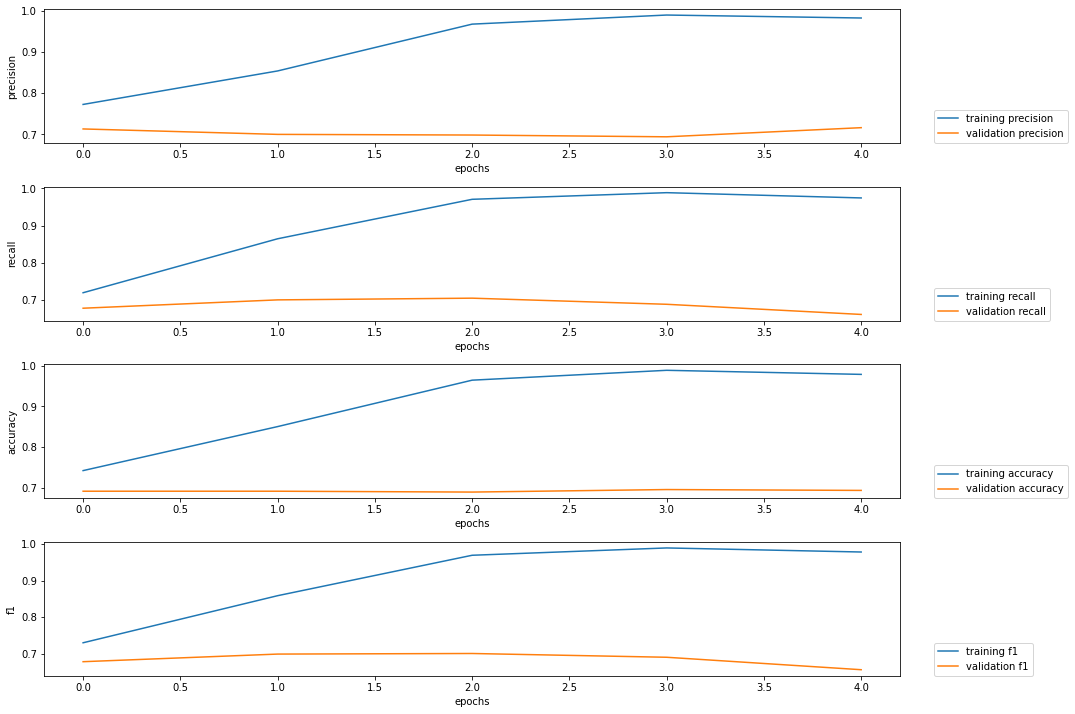

In [112]:
plotter.plot_training_curves('../output/loss.tsv', ["precision", "recall", "accuracy", "f1"])

Sprawdzamy pole pod wykresem (AUC) z najlepszego modelu (best_model.pt) na wydzielonych danych testowych (test.txt)

In [113]:
classifier = TextClassifier.load('../output/best-model.pt')

2021-02-07 22:53:34,082 loading file ../output/best-model.pt


In [120]:
validation_test = pd.read_csv('../output/test.txt', sep='\t', header=None)

In [123]:
validation_test['is_fake'] = validation_test[0].apply(lambda x: x[-1])

In [125]:
y_true_test = validation_test['is_fake']

In [176]:
%time y_pred_test = validation_test[1].map(make_pred)

IndexError: list index out of range

In [133]:
%time y_pred_proba_test = validation_test[1].map(make_pred_probability)

IndexError: list index out of range

In [167]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_test, y_pred_test, pos_label=1)
metrics.auc(fpr, tpr)

NameError: name 'y_pred_test' is not defined

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_test, y_pred_proba_test, pos_label=1)
metrics.auc(fpr, tpr)

Sprawdzamy pole pod wykresem (AUC) z najlepszego modelu (best_model.pt) na wydzielonych danych walidacyjnych (dev.txt)

In [178]:
validation_dev = pd.read_csv('../output/dev.txt', sep='\t', header=None)
validation_dev['is_fake'] = validation_dev[0].apply(lambda x: x[-1])
y_true_dev = validation_dev['is_fake']
y_true_dev = y_true_dev.astype(int)

In [179]:
%time y_pred_dev = validation_dev[1].map(make_pred)

IndexError: list index out of range

In [ ]:
%time y_pred_proba_dev = validation_dev[1].map(make_pred_probability)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_dev, y_pred_dev, pos_label=1)
metrics.auc(fpr, tpr)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_dev, y_pred_proba_dev, pos_label=1)
metrics.auc(fpr, tpr)

Na koniec wyliczamy AUC na zbiorze treningowym

In [ ]:
validation_train = pd.read_csv('../output/train.txt', sep='\t', header=None)
validation_train['is_fake'] = validation_train[0].apply(lambda x: x[-1])
y_true_train = validation_train['is_fake']
y_true_train = y_true_train.astype(int)

In [ ]:
%time y_pred_train = validation_train[1].map(make_pred)

In [ ]:
%time y_pred_proba_train = validation_train[1].map(make_pred_probability)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_train, y_pred_train, pos_label=1)
metrics.auc(fpr, tpr)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_train, y_pred_proba_train, pos_label=1)
metrics.auc(fpr, tpr)

PREDYKCJA NA GŁÓWNYM ZBIORZE TESTOWYM

In [ ]:
%time df_test['is_fake_bin'] = df_test['topic_and_text_with_title'].map(make_pred)

In [ ]:
%time df_test['is_fake'] = df_test['topic_and_text_with_title'].map(make_pred_probability)

In [ ]:
df_test[df_test['is_fake_bin'] == 1].shape

Zapisujemy wynik predykcji do pliku csv

In [ ]:
df_test[ ['id', 'is_fake'] ].to_csv('../output/best_model_prediction.csv', index=False)